In [2]:
import numpy as np
import os

from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist

encoding_dim = 32 # using 32 floats i.e. 32-dimensional input, compression factor of 24.5 (= 784 / 32)
input_img = Input(shape=(784,)) # input placeholder

encoded = Dense(encoding_dim, activation = 'relu')(input_img) # encoded representation of image
decoded = Dense(784, activation = 'sigmoid')(encoded) # decoded reconstruction of the input

autoencoder = Model(input_img, decoded) # meaning this model maps an input to its reconstruction; input vs output

encoder = Model(input_img, encoded) # meaning this model maps an input to its encoded representation
encoded_input = Input(shape=(encoding_dim,)) # placeholder for an encoded 32-dimensional input
decoder_layer = autoencoder.layers[-1] # retrieving the last layer of the autoencoder model
decoder = Model(encoded_input, decoder_layer(encoded_input)) # creating decoder model

autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy') # Per-pixel binary crossentropy loss
                                                                          # the Adadelta optimizer

(x_train, _), (x_test, _) = mnist.load_data() # load test data
x_train = x_train.astype('float32') / 255 # normalizing datasets to values [0,1]
x_test = x_test.astype('float32') / 255 # normalizing datasets to values [0,1]
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # flattening images into vectors of size 784
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))) # flattening images into vectors of size 784
print (x_train.shape)
print (x_test.shape)

autoencoder.fit (x_train, x_train,
                epochs = 50,
                batch_size = 256,
                shuffle = True,
                validation_data = (x_test, x_test))

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.3781 - val_loss: 0.2735
Epoch 2/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.2664 - val_loss: 0.2562
Epoch 3/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2452 - val_loss: 0.2317
Epoch 4/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.2237 - val_loss: 0.2136
Epoch 5/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.2086 - val_loss: 0.2010
Epoch 6/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.1977 - val_loss: 0.1917
Epoch 7/50
60000/60000 [==============================] - 5s 76us/step - loss: 0.1893 - val_loss: 0.1842
Epoch 8/50
60000/60000 [==============================] - 5s 76us/step - loss: 0.1823 - val_loss: 0.1776
Epoch 9/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.176

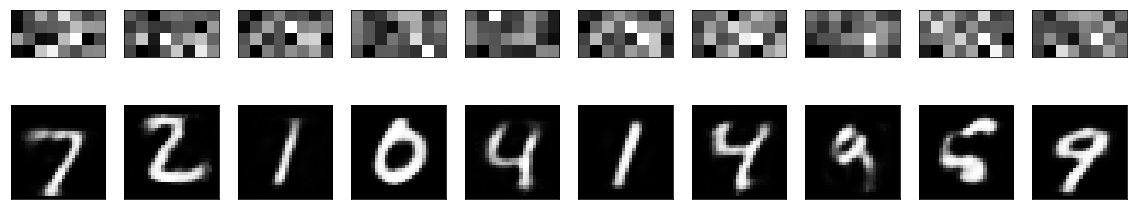

In [4]:
encoded_imgs = encoder.predict(x_test) # encode images from TEST set!
decoded_imgs = decoder.predict(encoded_imgs) # decode the former encoded images

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(x_test[i].reshape(28, 28))
    plt.imshow(encoded_imgs[i].reshape(4,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

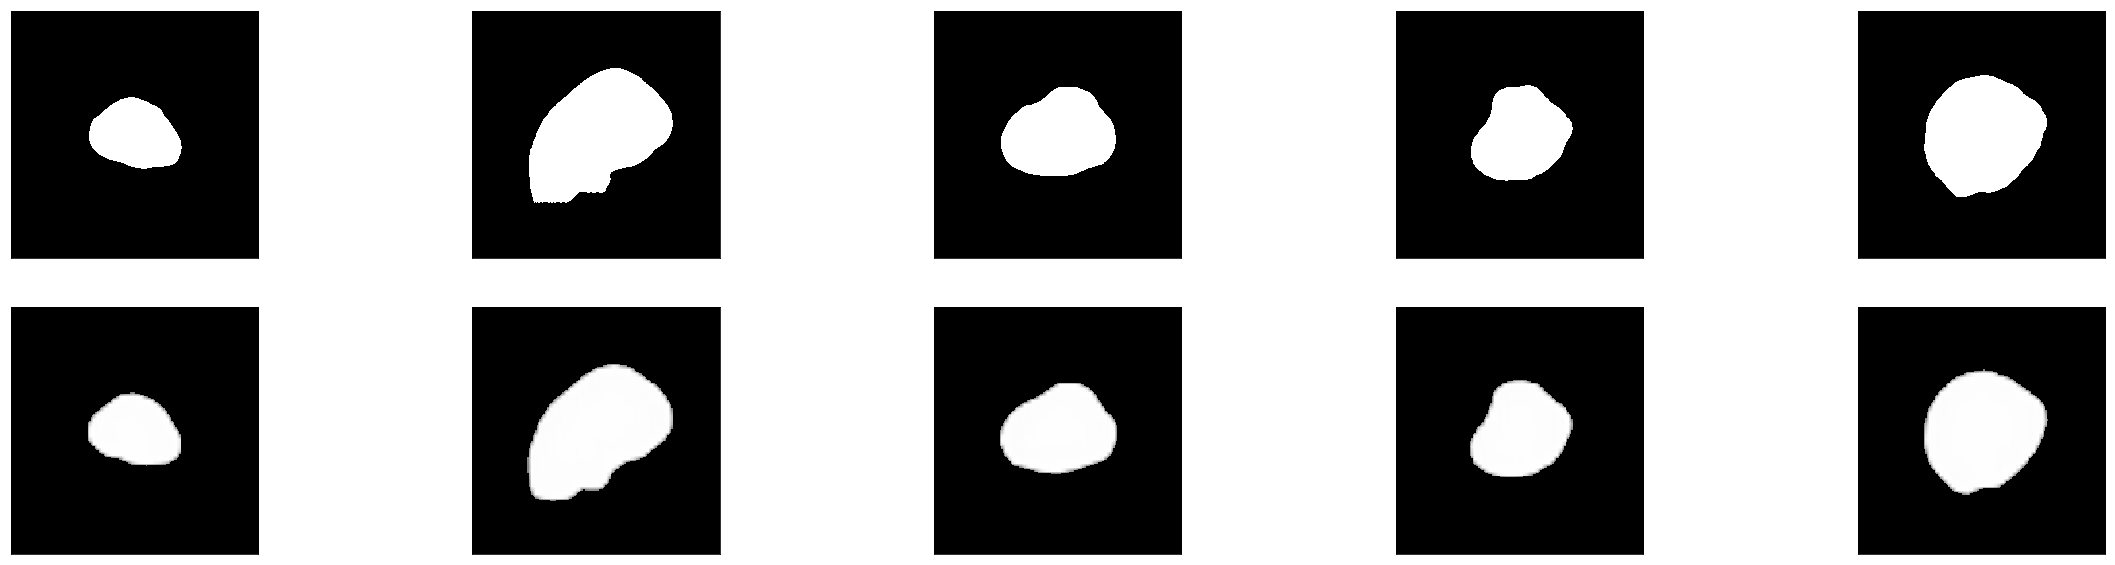

In [6]:
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(image_set)
#decoded_imgs = autoencoder.predict(image_set)

n = 5
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image_set[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
np.save()

(array([117, 117, 117, ..., 147, 148, 148]), array([89, 90, 97, ..., 82, 81, 82]), array([0, 0, 0, ..., 0, 0, 0]))


In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.models import Model
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, ThresholdedReLU, BatchNormalization
from keras.constraints import min_max_norm
from keras import backend as K
import tensorflow as tf

# print(os.getcwd())

# set print threshold for np
np.set_printoptions(threshold=10)

np.random.seed(1)

# load training set, matrix 2418 * 256 * 256 i.e. 2418 examples of 256*256 pictures
image_set = np.load('training1.npy')
image_set = np.reshape(image_set, (len(image_set), 256, 256, 1)) # define picture Tensor
image_set_size = image_set.shape[0]
training_set = image_set[0:(np.round(image_set_size*0.8)).astype('int'),]
validation_set = image_set[(np.round(image_set_size*0.8)).astype('int'):image_set_size,]

print(training_set.shape)
print(validation_set.shape)


input_img = Input(shape=(256, 256, 1))
print(input_img)


x = Conv2D(32, (1, 1), activation = "relu", padding = "same")(input_img)
x = MaxPooling2D((2, 2), padding = "same")(x)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = MaxPooling2D((2, 2), padding = "same")(x)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = MaxPooling2D((2, 2), padding = "same")(x) 
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
encoded = MaxPooling2D((2, 2), padding = "same")(x) # at this point the representation is (16, 16, 8) i.e. 2048-dim
print(encoded)

x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (1, 1), activation = "relu", padding = "same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(x)

def normalization(x):
    prod = tf.divide(tf.subtract(x, K.min(x)), tf.subtract(K.max(x), K.min(x)))
    return prod

decoded = Lambda(normalization)(decoded)
decoded = ThresholdedReLU(theta = 0.5)(decoded)

# end of network

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = "adadelta", loss = "mean_squared_error", metrics=['acc', 'mse'])
encoder = Model(input_img, encoded)

history = autoencoder.fit(training_set, training_set,
                epochs=100,
                batch_size=60,
                shuffle=True,
                validation_data=(validation_set, validation_set)) # batch_size = 120, mini-batch optim.!

autoencoder.save("jedra_model_metrics_minmaxnorm_threshrelu_MSE.h5")

/home/vid/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


(1934, 256, 256, 1)
(484, 256, 256, 1)
Tensor("input_1:0", shape=(?, 256, 256, 1), dtype=float32)
Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 16, 16, 8), dtype=float32)
Train on 1934 samples, validate on 484 samples
Epoch 1/100
1934/1934 [==============================] - 288s 149ms/step - loss: 0.1378 - acc: 0.7803 - mean_squared_error: 0.1378 - val_loss: 0.0875 - val_acc: 0.9044 - val_mean_squared_error: 0.0875
Epoch 2/100
1934/1934 [==============================] - 288s 149ms/step - loss: 0.0794 - acc: 0.9145 - mean_squared_error: 0.0794 - val_loss: 0.0681 - val_acc: 0.9314 - val_mean_squared_error: 0.0681
Epoch 3/100
1934/1934 [==============================] - 285s 148ms/step - loss: 0.0381 - acc: 0.9542 - mean_squared_error: 0.0381 - val_loss: 0.0194 - val_acc: 0.9729 - val_mean_squared_error: 0.0194
Epoch 4/100
1934/1934 [==============================] - 285s 148ms/step - loss: 0.0166 - acc: 0.9745 - mean_squared_error: 0.0166 - val_loss: 0.0138 - val_acc: 0.9788 - val_mean_

Epoch 81/100
1934/1934 [==============================] - 286s 148ms/step - loss: 0.0028 - acc: 0.9958 - mean_squared_error: 0.0028 - val_loss: 0.0026 - val_acc: 0.9969 - val_mean_squared_error: 0.0026
Epoch 82/100
1934/1934 [==============================] - 284s 147ms/step - loss: 0.0029 - acc: 0.9958 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_acc: 0.9943 - val_mean_squared_error: 0.0029
Epoch 83/100
1934/1934 [==============================] - 284s 147ms/step - loss: 0.0029 - acc: 0.9958 - mean_squared_error: 0.0029 - val_loss: 0.0027 - val_acc: 0.9970 - val_mean_squared_error: 0.0027
Epoch 84/100
1934/1934 [==============================] - 283s 147ms/step - loss: 0.0027 - acc: 0.9959 - mean_squared_error: 0.0027 - val_loss: 0.0028 - val_acc: 0.9946 - val_mean_squared_error: 0.0028
Epoch 85/100
1934/1934 [==============================] - 286s 148ms/step - loss: 0.0028 - acc: 0.9958 - mean_squared_error: 0.0028 - val_loss: 0.0026 - val_acc: 0.9969 - val_mean_squared_erro

dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'loss', 'acc', 'mean_squared_error'])


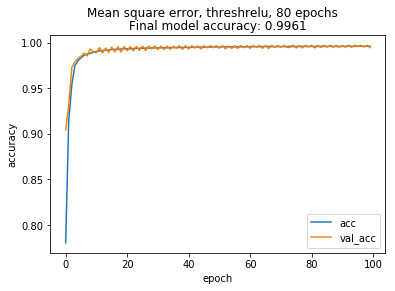

In [3]:
import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['acc'], label = "acc")
plt.plot(history.history['val_acc'], label = "val_acc")
plt.suptitle('Mean square error, threshrelu, 80 epochs')
acc = np.around(history.history['acc'][len(history.history['acc'])-1], decimals = 4)
plt.title('Final model accuracy: %s' %acc)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig('accuracy_minmaxnorm_thresholdedrelu_MSE.png')
plt.show()

dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'loss', 'acc', 'mean_squared_error'])


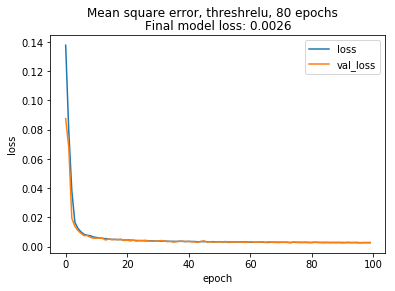

In [4]:
print(history.history.keys())
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.suptitle('Mean square error, threshrelu, 80 epochs')
loss = np.around(history.history['loss'][len(history.history['loss'])-1], decimals = 4)
plt.title('Final model loss: %s' %loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss_minmaxnorm_thresholdedrelu_MSE.png')
plt.show()

In [ ]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.models import Model
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, ThresholdedReLU, BatchNormalization
from keras.layers import Flatten, Reshape, Conv2DTranspose
from keras.constraints import min_max_norm
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

# print(os.getcwd())

# set print threshold for np
np.set_printoptions(threshold=10)

np.random.seed(1)

batch_size = 64
epochs = 40
latent_dim = 2
intermediate_dim = 512

# load training set, matrix 2418 * 256 * 256 i.e. 2418 examples of 256*256 pictures
image_set = np.load('training1.npy')
image_set = np.reshape(image_set, (len(image_set), 256, 256, 1)) # define picture Tensor
image_set_size = image_set.shape[0]
training_set = image_set[0:(np.round(image_set_size*0.8)).astype('int'),]
validation_set = image_set[(np.round(image_set_size*0.8)).astype('int'):image_set_size,]

print(training_set.shape)
print(validation_set.shape)


input_img = Input(shape=(256, 256, 1))
print(input_img)


x = Conv2D(32, (1, 1), activation = "relu", padding = "same")(input_img)
x = MaxPooling2D((2, 2), padding = "same")(x)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = MaxPooling2D((2, 2), padding = "same")(x)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = MaxPooling2D((2, 2), padding = "same")(x) 
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = MaxPooling2D((2, 2), padding = "same")(x) # at this point the representation is (16, 16, 8) i.e. 2048-dim
flat = Flatten()(x)

hidden = Dense(intermediate_dim, activation = "relu")(flat)
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean = 0., stddev = 1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])

hidden_decoded = Dense(intermediate_dim, activation = "relu")(z)
hidden_upsampled = Dense(2048, activation = "relu")(hidden_decoded)
hidden_reshaped = Reshape((16, 16, 8))(hidden_upsampled)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(hidden_reshaped)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (1, 1), activation = "relu", padding = "same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(x)
print(decoded)

#def normalization(x):
#    prod = tf.divide(tf.subtract(x, K.min(x)), tf.subtract(K.max(x), K.min(x)))
#    return prod

#decoded = Lambda(normalization)(decoded)
#decoded = ThresholdedReLU(theta = 0.5)(decoded)
# end of network

# encoder; from inputs to latent space
encoder = Model(input_img, z_mean)

# generator; from latent space to reconstructed inputs
generator_input = Input(shape=(latent_dim,))
_hidden_decoded = Dense(intermediate_dim, activation = "relu")(generator_input)
_hidden_upsampled = Dense(2048, activation = "relu")(_hidden_decoded)
_hidden_reshaped = Reshape((16, 16, 8))(_hidden_upsampled)
_x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(_hidden_reshaped)
_x = UpSampling2D((2, 2))(_x)
_x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(_x)
_x = UpSampling2D((2, 2))(_x)
_x = Conv2D(8, (3, 3), activation = "relu", padding = "same")(_x)
_x = UpSampling2D((2, 2))(_x)
_x = Conv2D(32, (1, 1), activation = "relu", padding = "same")(_x)
_x = UpSampling2D((2, 2))(_x)
_decoded = Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(_x)
generator = Model(generator_input, _decoded)

# end-to-end autoencoder
vae = Model(input_img, decoded)

def vae_loss(input_img, decoded):
    xent_loss = binary_crossentropy(K.flatten(input_img), K.flatten(decoded))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
    return K.mean(xent_loss + kl_loss)

vae.compile(optimizer = "rmsprop", loss = vae_loss, metrics = ["acc", "mae"])
vae.summary()

history = vae.fit(training_set, training_set,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(validation_set, validation_set))
                
vae.save("jedra_model_VAE.h5")

(1934, 256, 256, 1)
(484, 256, 256, 1)
Tensor("input_7:0", shape=(?, 256, 256, 1), dtype=float32)
Tensor("conv2d_51/Sigmoid:0", shape=(?, 256, 256, 1), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 256, 32) 64          input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 12

In [6]:
output_shape = (64, 256, 256, 32)
print(output_shape[1:])

(256, 256, 32)


In [8]:
vae.save("jedra_model_VAE.h5")

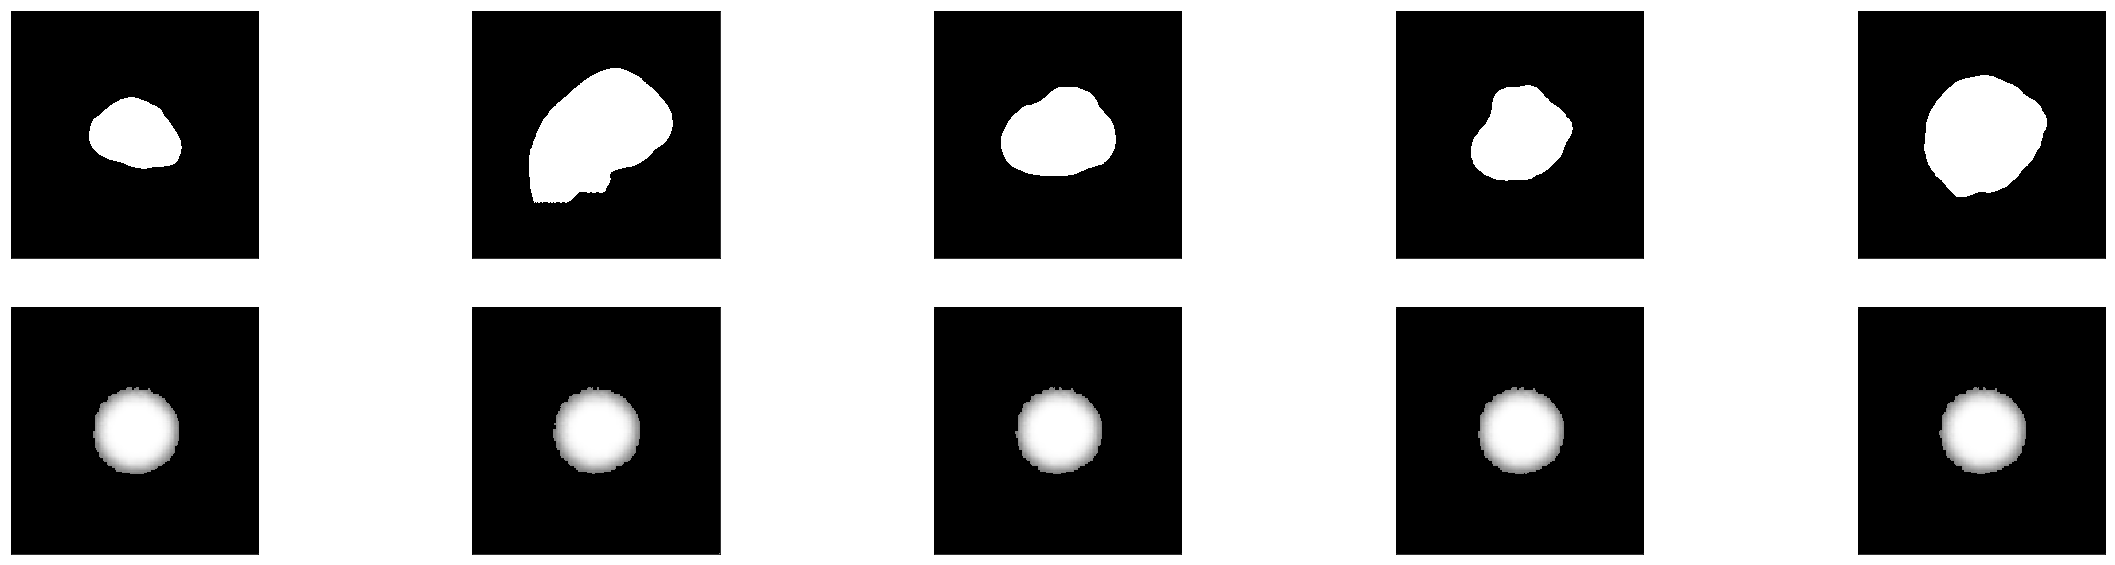

In [8]:
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(image_set)
decoded_imgs = vae.predict(image_set)

n = 5
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image_set[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()